In [1]:
import pickle 

import imp
from IPython.display import clear_output, display
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

from context import rf_pool

In [2]:
from rf_pool import models, modules, layers, ops
from rf_pool.utils import lattice, functions, visualize, datasets, stimuli

In [23]:
imp.reload(datasets)

<module 'rf_pool.utils.datasets' from '/global/home/users/joel_bowen/rf_pool/rf_pool/utils/datasets.py'>

**Load MNIST Data**

In [3]:
path_to_models = '/global/home/groups/fc_streams/models'
path_to_data = '/global/home/groups/fc_streams/data'

In [4]:
# get MNIST training data
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root=path_to_data, train=True, download=True, 
                                       transform=transform)
testset = torchvision.datasets.MNIST(root=path_to_data, train=False, download=True,
                                     transform=transform)

In [5]:
# create trainloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

In [ ]:
# load base set crowded i
base_set = pickle.load(open('crowding_experiment/MNIST_CrowdedDataset.pkl', 'rb'))

# Set up the models

## Crowded Model

In [6]:
# initialize model
model = rf_pool.models.FeedForwardNetwork()

In [7]:
# append layers of model
model.append('0', rf_pool.modules.FeedForward(hidden=torch.nn.Conv2d(1,32,5),
                                              activation=torch.nn.ReLU(), 
                                              pool=torch.nn.MaxPool2d(2)))
model.append('1', rf_pool.modules.FeedForward(hidden=torch.nn.Conv2d(32,64,5),
                                              activation=torch.nn.ReLU(),
                                              pool=torch.nn.MaxPool2d(2)))
model.append('2', rf_pool.modules.FeedForward(hidden=torch.nn.Conv2d(64,10,4)))
model.append('3', rf_pool.modules.FeedForward(input_shape=(-1,10)))

In [ ]:
# load previous model and results
(_, extras) = model.load_model('crowding_experiment/attention_3deg.pkl')
interference_crop = extras.get('interference_crop')
similarity_rfs = extras.get('similarity_rfs')

In [ ]:
# remove reshape layer 
model.layers.pop('3')

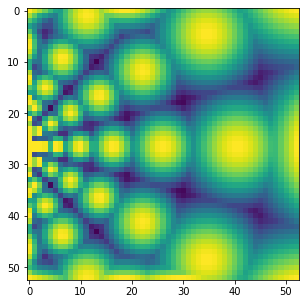

torch.Size([53, 2])


In [8]:
# update RF layer with attention at target location
def set_rf_layer(offest):
    img_shape = torch.Size((53,53))
    mu, sigma = rf_pool.utils.lattice.init_foveated_lattice(img_shape, 0.23, 0., n_rf=None, n_rings=11, 
                                                            offset=offset, rotate_rings=False)
    rf_layer = rf_pool.layers.RF_Pool(mu=mu, sigma=sigma, img_shape=img_shape, 
                                      lattice_fn=rf_pool.utils.lattice.mask_kernel_lattice,
                                      pool_type=None, kernel_size=2, thr=np.exp(-1.))
    rf_layer.show_lattice()
    n_kernels = rf_layer.mu.shape[0]

    layer_id = '1'
    model.layers[layer_id].forward_layer.add_module('pool', rf_layer)

## Evaluation Classifier

In [27]:
# append layers of model
def init_classifier():
    eval_classifier = rf_pool.models.FeedForwardNetwork()
    eval_classifier.append('0', rf_pool.modules.FeedForward(input_shape=(-1,3392)))
    eval_classifier.append('1', rf_pool.modules.FeedForward(hidden=torch.nn.Linear(3392,1500),
                                                  activation=torch.nn.ReLU()))
    eval_classifier.append('2', rf_pool.modules.FeedForward(hidden=torch.nn.Linear(1500,500),
                                                           activation=torch.nn.ReLU()))
    eval_classifier.append('3', rf_pool.modules.FeedForward(hidden=torch.nn.Linear(500,10)))
    
    return eval_classifier


# Train the classifiers

**Set functions for experiments**

In [14]:
def get_crowd_params(crowd_type):
    # number of flankers
    if crowd_type in ['outer','inner']:
        n_flankers = 1
    else:
        n_flankers = 2
    # axis
    if crowd_type == 'inner':
        axis = np.pi
    else:
        axis = 0.
    # rf layer offset
    if crowd_type == 'tangential':
        set_rf_layer([-30.,0.])
    else:
        set_rf_layer([0.,-30.])
        
    return n_flankers, axis

def create_crowd_set(dataset, n_images, img_size, n_flankers, axis, spacing, base_set=None,
                     label_map=None, no_target=False):
    if base_set is None:
        crowd_set = datasets.CrowdedDataset(dataset, n_flankers, n_images, no_target=no_target,
                                            load_previous=False, label_map=label_map,
                                            transform=transforms.ToTensor(),
                                            spacing=20*spacing, background_size=img_size, axis=axis)
    else:
        crowd_set = datasets.CrowdedDataset(dataset, n_flankers, n_images,
                                            base_set.recorded_target_indices,
                                            base_set.recorded_flanker_indices,
                                            no_target=no_target,
                                            load_previous=True, label_map=label_map,
                                            transform=transforms.ToTensor(),
                                            spacing=20*spacing, background_size=img_size, axis=axis)
    return crowd_set

In [15]:
def get_rf_output(model, inputs, layer_id):
    rf_out = model.rf_output(inputs, layer_id, retain_shape=True)
    return torch.max(rf_out.flatten(-2), -1)[0].flatten(1)

def gather_features_labels(data_loader, model, layer_id):
    features = []
    feature_labels = []
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            img, label = data
            feature = get_rf_output(model, img, layer_id)
            features.append(feature)
            feature_labels. append(label)

    return torch.cat(features, 0), torch.cat(feature_labels, 0)


In [28]:
def train_classifier(n_epochs, train_loader, test_loader, model_filename, **kwargs):
    # initialize the classifier
    eval_model = init_classifier()
    # set loss function and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), **kwargs)
    eval_model.train(n_epochs, train_loader, loss_fn, optim, monitor=100,
                            show_weights={'layer_id': '0', 'cmap': 'gray'})
                           
    eval_model.save_model(model_filename)                                  
    return eval_model.get_accuracy(test_loader)                   

**Spacings**

In [30]:
# directories
data_root_directory = path_to_data + '/crowded_features'
model_root_directory = path_to_models + '/crowded_classifiers'

for root_dir in [data_root_directory, model_root_directory]:
    if not os.path.exists(root_dir):
        os.mkdir(root_dir)

base_train = None
base_test = None

# set batch size, image size, and test size
batch_size = 1
img_size = 118
n_train = 50
n_test = 10

# set independent variables
crowded_types = ['radial','inner', 'outer','tangential']
spacings = np.arange(1,2.25,.25)
label_map = {}
label_map.update([(n,n) for n in range(10)])

# classifier params
n_epochs = 1
ft_batch_size=10
lr = .001
momentum = 0.9

In [21]:
# gather the features seperately before training
for crowd_type in crowded_types: 
    for sp in spacings:
        # get the crowded sets
        n_flankers, axis = get_crowd_params(crowd_type)
        # train set
        train_crowd = create_crowd_set(trainset, n_train, img_size, n_flankers, axis, sp, base_train, label_map)
        trainloader_crowd = torch.utils.data.DataLoader(train_crowd, batch_size=batch_size, shuffle=False, num_workers=2)
        ft_train_data = gather_features_labels(trainloader_crowd, model, '1')
        torch.save(ft_train_data, data_root_directory + '/' +str(sp)+ '_train')
        # test set
        test_crowd = create_crowd_set(testset, n_test, img_size, n_flankers, axis, sp, base_test, label_map)
        testloader_crowd = torch.utils.data.DataLoader(test_crowd, batch_size=batch_size, shuffle=False, num_workers=2)
        ft_test_data = gather_features_labels(testloader_crowd, model, '1')
        torch.save(ft_test_data, data_root_directory + '/' + str(sp)+ '_test')
        
        print('Saved features: Crowded type: {}; Spacing: {}'.format(crowd_type, sp))
        

Saved features: Crowded type: radial; Spacing: 1.0


In [31]:
# train the classifiers and compute accuracy
accuracy = {'spacings': spacings,
            'inner': [],
            'outer':[],
            'radial':[],
            'tangential':[]}

for crowd_type in crowded_types: 
    for sp in spacings:
        # load in the feature datasets
        # trainset
        ft_train = datasets.FeatureDataset(root=data_root_directory+'/'+str(sp), train=True,
                                           transform=transforms.ToTensor())
        ft_trainloader = torch.utils.data.DataLoader(ft_train, batch_size=ft_batch_size, shuffle=True, num_workers=2)
        # test set
        ft_test = datasets.FeatureDataset(root=data_root_directory+'/'+str(sp), train=False,
                                          transform=transforms.ToTensor())
        ft_testloader = torch.utils.data.DataLoader(ft_test, batch_size=ft_batch_size, shuffle=True, num_workers=2)
        
        # train
        classifier_save_filename =  model_root_directory + '/' + str(sp)
        acc = train_classifier(n_epochs, ft_trainloader, ft_testloader, classifier_save_filename,
                               lr=lr, momentum=momentum)
        
        accuracy[crowd_type].append(acc)
        print('Saved classifier: Crowded type: {}; Spacing: {}'.format(crowd_type, sp))
          

Saved classifier: Crowded type: radial; Spacing: 1.0


In [32]:
accuracy

{'spacings': [1.0],
 'inner': [],
 'outer': [],
 'radial': [10.0],
 'tangential': []}

**Extent of attention**

In [ ]:
def apply_attention_field(model, layer_id, mu, sigma, loc, extent):
    # update rfs with spatial extent
    img_shape = model.layers[layer_id].forward_layer.pool.get(['img_shape'])[0]
    attn_field = torch.zeros(img_shape)
    attn_field[loc[0],loc[1]] = 1./extent
    new_mu, new_sigma = lattice.update_mu_sigma(mu, sigma, attn_field)
    model.layers[layer_id].forward_layer.pool.set(mu=new_mu, sigma=new_sigma)
    return model